# Project 4: Web Scraping Job Postings

<font color='blue'>

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required 
      skills accurately predict job title?

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from textblob import TextBlob

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_columns', None)

### 1.0 Import and Clean Scraped Job Listings

In [2]:
# Import job listings into dataframe

file = "./jobslist_updated.csv"
jobs = pd.read_csv(file)

In [3]:
jobs.shape

(4000, 13)

In [4]:
jobs.head(2)

,link,employer,location,employment_type,seniority,sector,pay_min,pay_max,pay_type,about,rr,requirements,job_title
0,/job/data-scientist-singapore-power-5731c18be1...,SINGAPORE POWER LIMITED,Central,Full Time,Professional,Information Technology,4000.0,8000.0,Monthly,A leading energy utility company in Asia Pacif...,Why Work for Us We Power the Nation. Make the...,What You'll Need We are looking for Passion an...,Data Scientist
1,/job/senior-data-scientist-singapore-power-b8f...,SINGAPORE POWER LIMITED,Central,Full Time,Middle Management,Information Technology,8000.0,14000.0,Monthly,A leading energy utility company in Asia Pacif...,Why Work for Us We Power the Nation. Make the...,What You'll Need We are looking for Passion an...,Senior Data Scientist


In [5]:
# Drop the link column as we no longer need this information
jobs.drop(columns='link', axis=1, inplace=True)

In [6]:
# Check for null values in the data
jobs.isnull().sum().sort_values(ascending=False)

about              2201
job_title           454
pay_type            433
pay_max             433
pay_min             433
requirements        166
location            144
seniority            68
rr                   28
sector                0
employment_type       0
employer              0
dtype: int64

In [7]:
# Fill null values in the about column with 'NA'
jobs.about.fillna('NA', inplace=True)

# For the rest of the columns, we will drop all rows with missing info. We still have more than enough data.
jobs.dropna(axis=0, how='any', inplace=True)

In [8]:
# Check for any duplicate listing
duplicate = jobs[jobs.duplicated()]

duplicate.shape

(113, 12)

In [9]:
# Drop duplicate rows
jobs.drop(duplicate.index, axis=0, inplace=True)
jobs.reset_index(drop=True, inplace=True)

In [10]:
# Reamaining dataset shape
jobs.shape

(2969, 12)

In [11]:
# Look at the column properties
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969 entries, 0 to 2968
Data columns (total 12 columns):
employer           2969 non-null object
location           2969 non-null object
employment_type    2969 non-null object
seniority          2969 non-null object
sector             2969 non-null object
pay_min            2969 non-null float64
pay_max            2969 non-null float64
pay_type           2969 non-null object
about              2969 non-null object
rr                 2969 non-null object
requirements       2969 non-null object
job_title          2969 non-null object
dtypes: float64(2), object(10)
memory usage: 278.4+ KB


#### 1.1 Standardize all pays to be monthly pay and create a new average pay column ('pay')

In [12]:
# Create new 'pay' column that takes the average of pay_min and pay_max
jobs['pay'] = round((jobs['pay_min'] + jobs['pay_max'])/2)

In [13]:
# Convert Annual pays to monthly pay by dividing annual pay by 13 months (12mths + 1mth AWS)
index = jobs[jobs.pay_type=='Annually'].index

jobs.loc[index, 'pay'] = round(jobs.loc[index, 'pay']/13)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


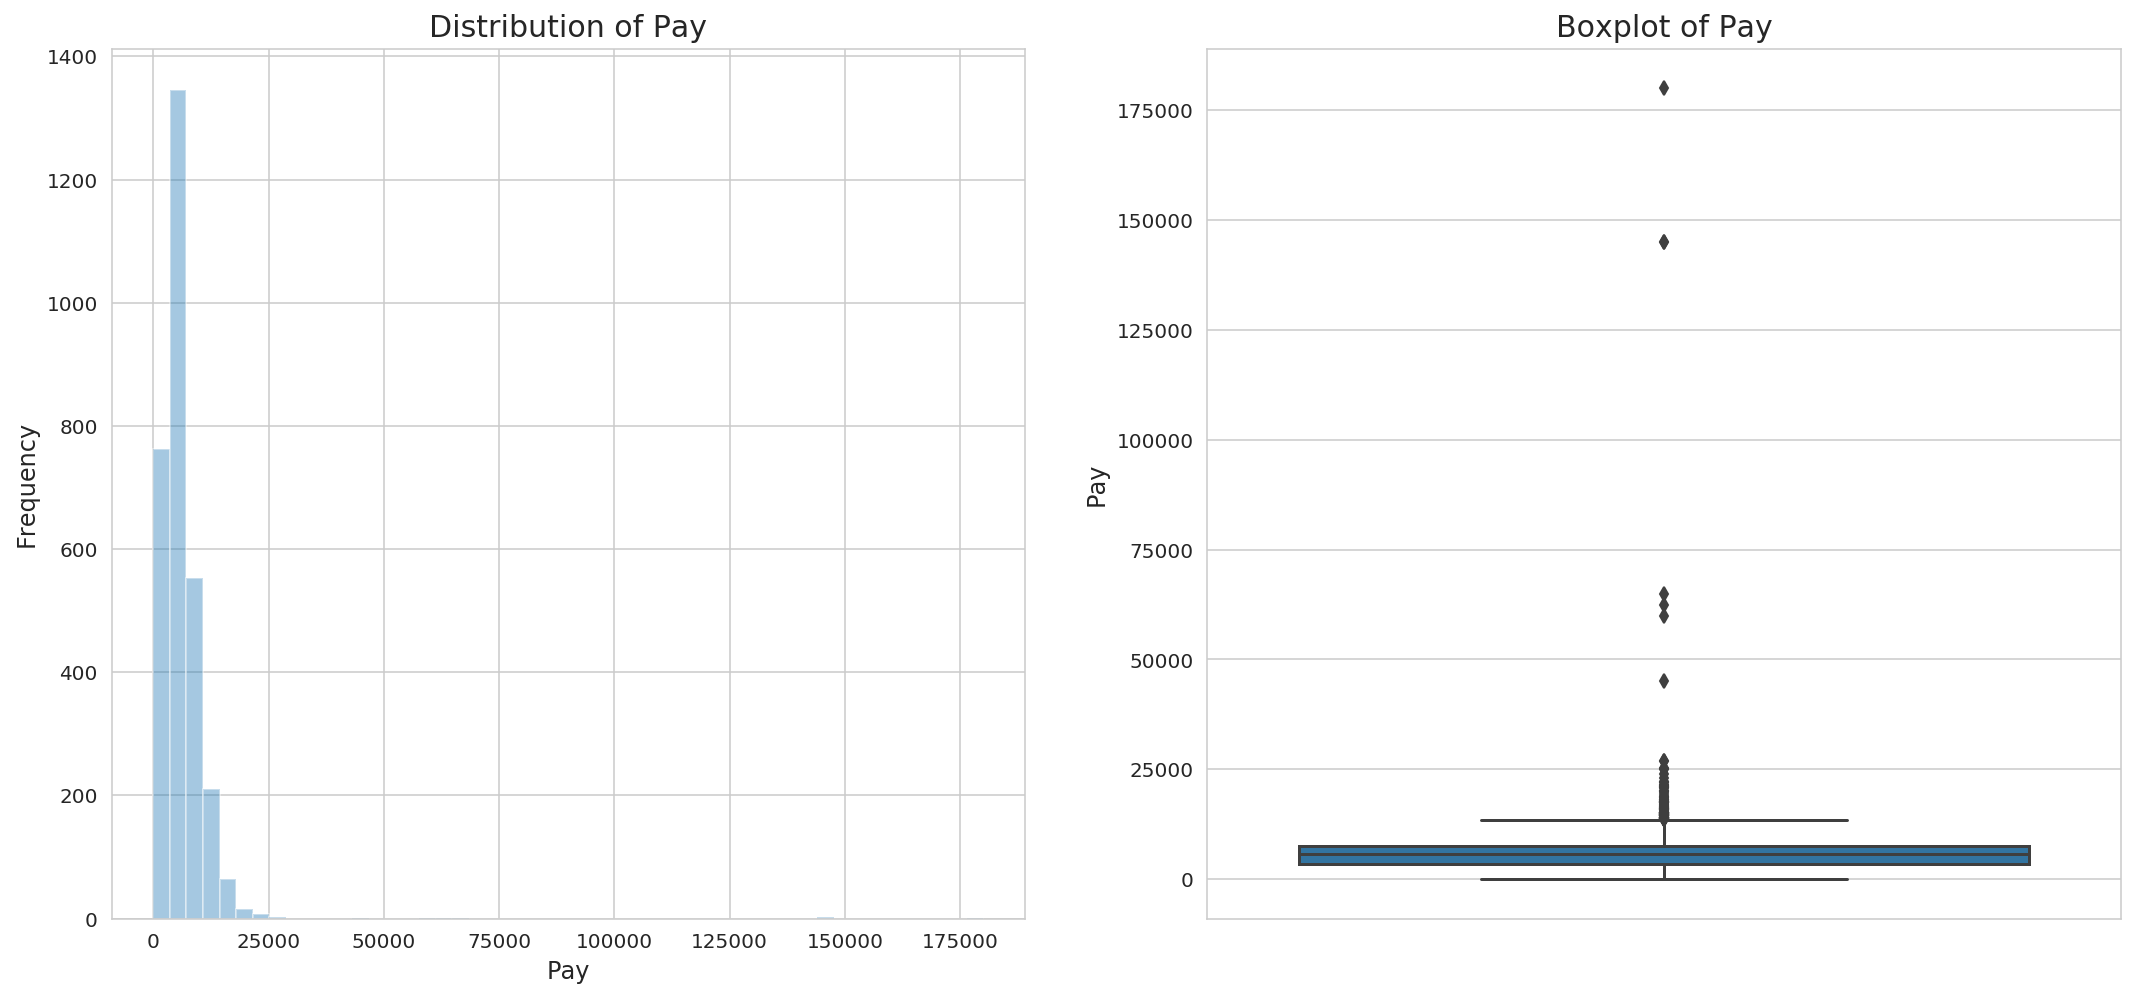

In [14]:
# Let's look at the pay distribution and check for outliers
fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0] = sns.distplot(jobs['pay'], kde=False, ax=ax[0])
ax[1] = sns.boxplot(data=jobs, y='pay', ax=ax[1])

#Set the x-y label parameters
#ax.set_xlabel('Job Location', fontsize=12)
ax[0].set_xlabel('Pay', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)

ax[1].set_ylabel('Pay', fontsize=12)

#Set the plot title
ax[0].set_title('Distribution of Pay', fontsize=15)
ax[1].set_title('Boxplot of Pay', fontsize=15)

plt.show()

In [15]:
#Let's look at those entries with pay above $40,000
jobs[jobs.pay>=40000].sort_values(by='pay', ascending=False)

,employer,location,employment_type,seniority,sector,pay_min,pay_max,pay_type,about,rr,requirements,job_title,pay
1186,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.,Central,Full Time,Middle Management,Banking and Finance ...,144000.0,216000.0,Monthly,SIX Financial Information Singapore Pte Ltd is...,The SSO group provides business support servic...,Main Duties 1. A key positive aspect of the SI...,Head of SSO (APAC),180000.0
1141,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.,Central,Full Time,Middle Management,Banking and Finance,120000.0,170000.0,Monthly,SIX Financial Information Singapore Pte Ltd is...,The new position is available in our Singapore...,Candidates should have a backgroud in selling ...,Senior Sales Manager,145000.0
2567,SIX FINANCIAL INFORMATION SINGAPORE PTE. LTD.,Central,Full Time,Middle Management,Banking and Finance ...,120000.0,170000.0,Monthly,SIX Financial Information Singapore Pte Ltd is...,The new position is available in our Singapore...,Candidates should have a backgroud in selling ...,Senior Sales Manager,145000.0
765,IHS MARKIT ASIA PTE. LTD.,Central,Permanent ...,Senior Executive,Banking and Finance,50000.0,80000.0,Monthly,\n\tMarkit is a leading global diversified pro...,Department overview: IHS Markit’s Dividend For...,Education and experience Undergraduate degr...,"Senior Associate, Research and Analysis (Korea...",65000.0
2409,DTCC DATA REPOSITORY (SINGAPORE) PTE. LTD.,Central,Full Time,Senior Executive,Information Technology,50000.0,75000.0,Monthly,NA,Business Unit Description: AD Derivatives is r...,Qualifications Minimum of 8 years’ experience...,Senior Business Systems Analyst,62500.0
491,ULTRA CLEAN ASIA PACIFIC PTE. LTD.,North,Permanent ...,Senior Management,Manufacturing,40000.0,80000.0,Monthly,NA,Designing and implementing business operation...,Pivotal Experience & Expertise Operational ex...,Chief Operationg Officer,60000.0
822,NCS PTE. LTD.,North,Permanent,Professional,Information Technology,5000.0,85000.0,Monthly,"NCS also delivers mobility, social media, p...","Position Summary Setup, deploy and maintain s...",Minimum 3 years of experience in database adm...,Lead / Senior Database Administrator,45000.0


In [16]:
# Most of these pays look like they should be annual pay rather than monthly (except for the COO pay).
#Let's fix them.

# Convert the pay for the following rows to monthly (divide by 13)
jobs.loc[1186, 'pay'] = round(jobs.loc[1186, 'pay']/13)
jobs.loc[1141, 'pay'] = round(jobs.loc[1141, 'pay']/13)
jobs.loc[2567, 'pay'] = round(jobs.loc[2567, 'pay']/13)
jobs.loc[765, 'pay'] = round(jobs.loc[765, 'pay']/13)
jobs.loc[2409, 'pay'] = round(jobs.loc[2409, 'pay']/13)

# Change the pay_max for row index 822 to $8500 and re-calculate the pay
jobs.loc[822, 'pay_max'] = 8500
jobs.loc[822, 'pay'] = (jobs.loc[822, 'pay_min'] + jobs.loc[822, 'pay_max'])/2

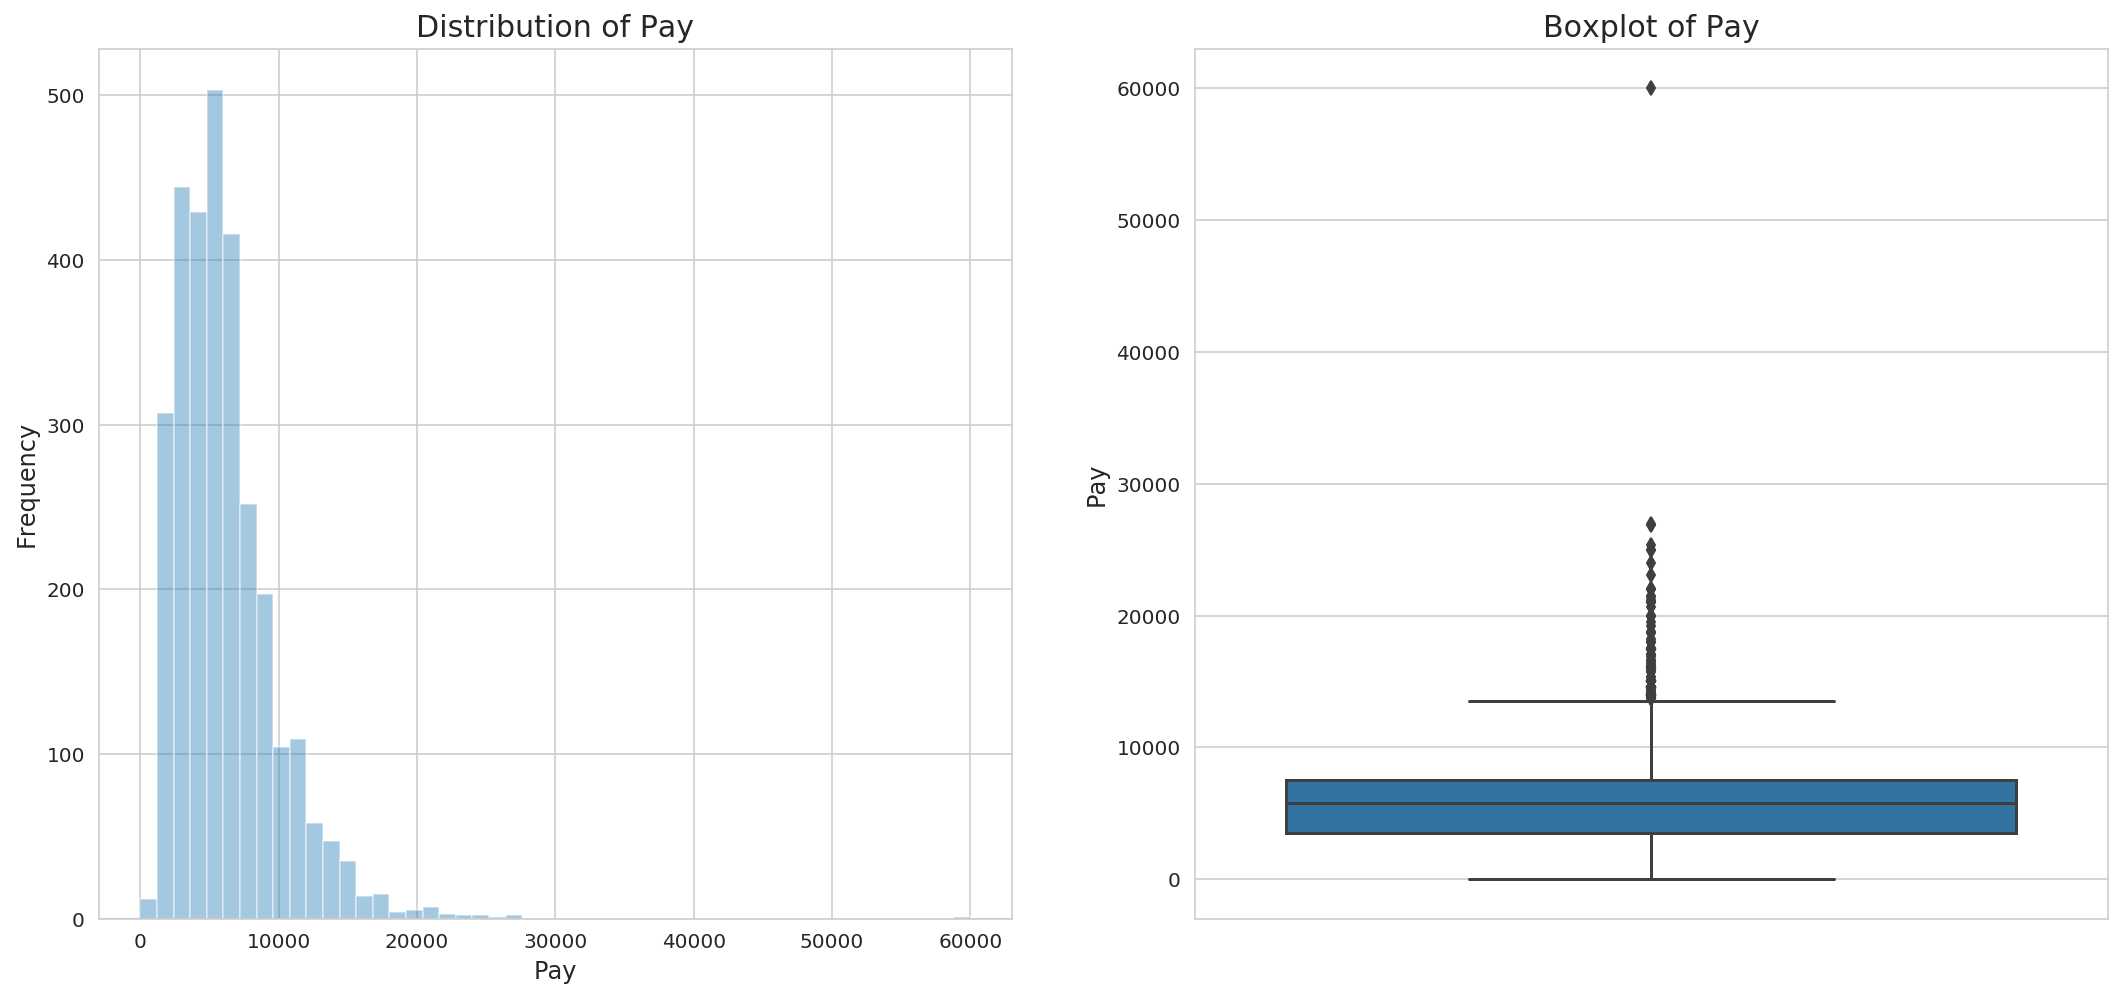

In [17]:
# Let's look at the pay distribution and boxplot after fixing the data
fig, ax = plt.subplots(ncols=2, figsize=(18,8))

ax[0] = sns.distplot(jobs['pay'], kde=False, ax=ax[0])
ax[1] = sns.boxplot(data=jobs, y='pay', ax=ax[1])

#Set the x-y label parameters
#ax.set_xlabel('Job Location', fontsize=12)
ax[0].set_xlabel('Pay', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)

ax[1].set_ylabel('Pay', fontsize=12)

#Set the plot title
ax[0].set_title('Distribution of Pay', fontsize=15)
ax[1].set_title('Boxplot of Pay', fontsize=15)

plt.show()

In [18]:
# Convert pay column to integer
jobs.pay = jobs.pay.astype(int)

In [19]:
# Drop the pay_min, pay_max and pay_type columns as these are no longer needed
jobs.drop(columns=['pay_min', 'pay_max', 'pay_type'], axis=1, inplace=True)

In [20]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969 entries, 0 to 2968
Data columns (total 10 columns):
employer           2969 non-null object
location           2969 non-null object
employment_type    2969 non-null object
seniority          2969 non-null object
sector             2969 non-null object
about              2969 non-null object
rr                 2969 non-null object
requirements       2969 non-null object
job_title          2969 non-null object
pay                2969 non-null int64
dtypes: int64(1), object(9)
memory usage: 232.0+ KB


#### 1.2 Clean-up the employment_type column

In [21]:
jobs.employment_type.value_counts()

Full Time        1086
Permanent         624
Permanent ...     611
Contract          295
Contract ...      266
Temporary ...      33
Temporary          21
Part Time ...      17
Internship          9
Part Time           3
Full Time ...       2
Freelance ...       1
Flexi work          1
Name: employment_type, dtype: int64

In [22]:
jobs.employment_type = jobs.employment_type.map(lambda x: x.replace(' ...', ''))

In [23]:
jobs.employment_type.value_counts()

Permanent     1235
Full Time     1088
Contract       561
Temporary       54
Part Time       20
Internship       9
Freelance        1
Flexi work       1
Name: employment_type, dtype: int64

#### 1.3 Clean-up the seniority column

In [24]:
jobs.seniority.value_counts()

Executive                588
Professional             518
Manager                  315
Senior Executive         298
Non-executive            263
Junior Executive         217
Middle Management        129
Senior Management        118
Fresh/entry level ...    110
Fresh/entry level        102
Professional ...          95
Executive ...             78
Manager ...               60
Middle Management ...     34
Senior Management ...     27
Non-executive ...         12
Junior Executive ...       5
Name: seniority, dtype: int64

In [25]:
jobs.seniority = jobs.seniority.map(lambda x: x.replace(' ...', ''))

In [26]:
jobs.seniority.value_counts()

Executive            666
Professional         613
Manager              375
Senior Executive     298
Non-executive        275
Junior Executive     222
Fresh/entry level    212
Middle Management    163
Senior Management    145
Name: seniority, dtype: int64

#### 1.4 Clean-up the sector column

In [27]:
jobs.sector.value_counts()

Information Technology                   842
Engineering                              216
Banking and Finance                      162
Accounting / Auditing / Taxation         143
Sciences / Laboratory / R&D              121
Admin / Secretarial                      117
Engineering ...                          117
Others                                   108
Human Resources                           91
Marketing / Public Relations              72
Logistics / Supply Chain                  64
Consulting  ...                           62
Accounting / Auditing / Taxation ...      62
Consulting                                60
Sales / Retail                            58
Admin / Secretarial ...                   56
Advertising / Media                       53
Banking and Finance ...                   47
Healthcare / Pharmaceutical               44
Building and Construction                 35
Manufacturing                             32
Education and Training                    28
Informatio

In [28]:
jobs.sector = jobs.sector.map(lambda x: x.replace(' ...', ''))

In [29]:
jobs.sector.value_counts()

Information Technology               869
Engineering                          333
Banking and Finance                  209
Accounting / Auditing / Taxation     205
Admin / Secretarial                  173
Consulting                           122
Sciences / Laboratory / R&D          121
Others                               116
Human Resources                       95
Marketing / Public Relations          83
Logistics / Supply Chain              79
Advertising / Media                   75
Sales / Retail                        58
Healthcare / Pharmaceutical           52
Building and Construction             50
Customer Service                      40
Manufacturing                         35
Education and Training                34
General Management                    27
Design                                24
Repair and Maintenance                22
Purchasing / Merchandising            17
Insurance                             14
F&B                                   14
Architecture / I

#### 1.5 Categorize the different job listings into categories

In [30]:
#jobs_filtered = jobs[jobs.job_title.str.contains('data|analy|data&engin|scien|business|intel|research|stat|visual' , case=False)]

In [31]:
#Let's try to group the job titles into different categories.

#Data Scientist
substring_list = ['data', 'scientist']
mask = [all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]
jobs.loc[mask,'title'] = 'Data Scientist'

#Data Analyst
substring_list = ['data', 'analy']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Data Analyst'

#Business Analyst
substring_list = ['business', 'analy']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Business Analyst'

#Data Engineer
substring_list = ['data', 'engin']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Data Engineer'

#Data (Others)
substring_list = ['data']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Data (Others)'

#Analyst (Others)
substring_list = ['analy']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Analyst (Others)'

#Developer
substring_list = ['developer']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Developer'

#Software (Others)
substring_list = ['software']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Software (Others)'

#Researcher
substring_list = ['research']
mask = np.array([all(substring in string.lower() for substring in substring_list) for string in jobs.job_title.values]) & \
       np.array([jobs.title.isnull().values])
jobs.loc[mask[0],'title'] = 'Researcher'

In [32]:
#Drop the remaining ungrouped jobs as they are not relavant to our field of interest
jobs.dropna(axis=0, subset=['title'], inplace=True)

In [33]:
jobs.shape

(939, 11)

In [34]:
jobs.title.value_counts()

Analyst (Others)     159
Researcher           140
Developer            132
Data (Others)        121
Software (Others)     98
Data Engineer         75
Data Scientist        73
Data Analyst          72
Business Analyst      69
Name: title, dtype: int64

<font color='blue'>

### 2.0 QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

#### 2.1 EDA

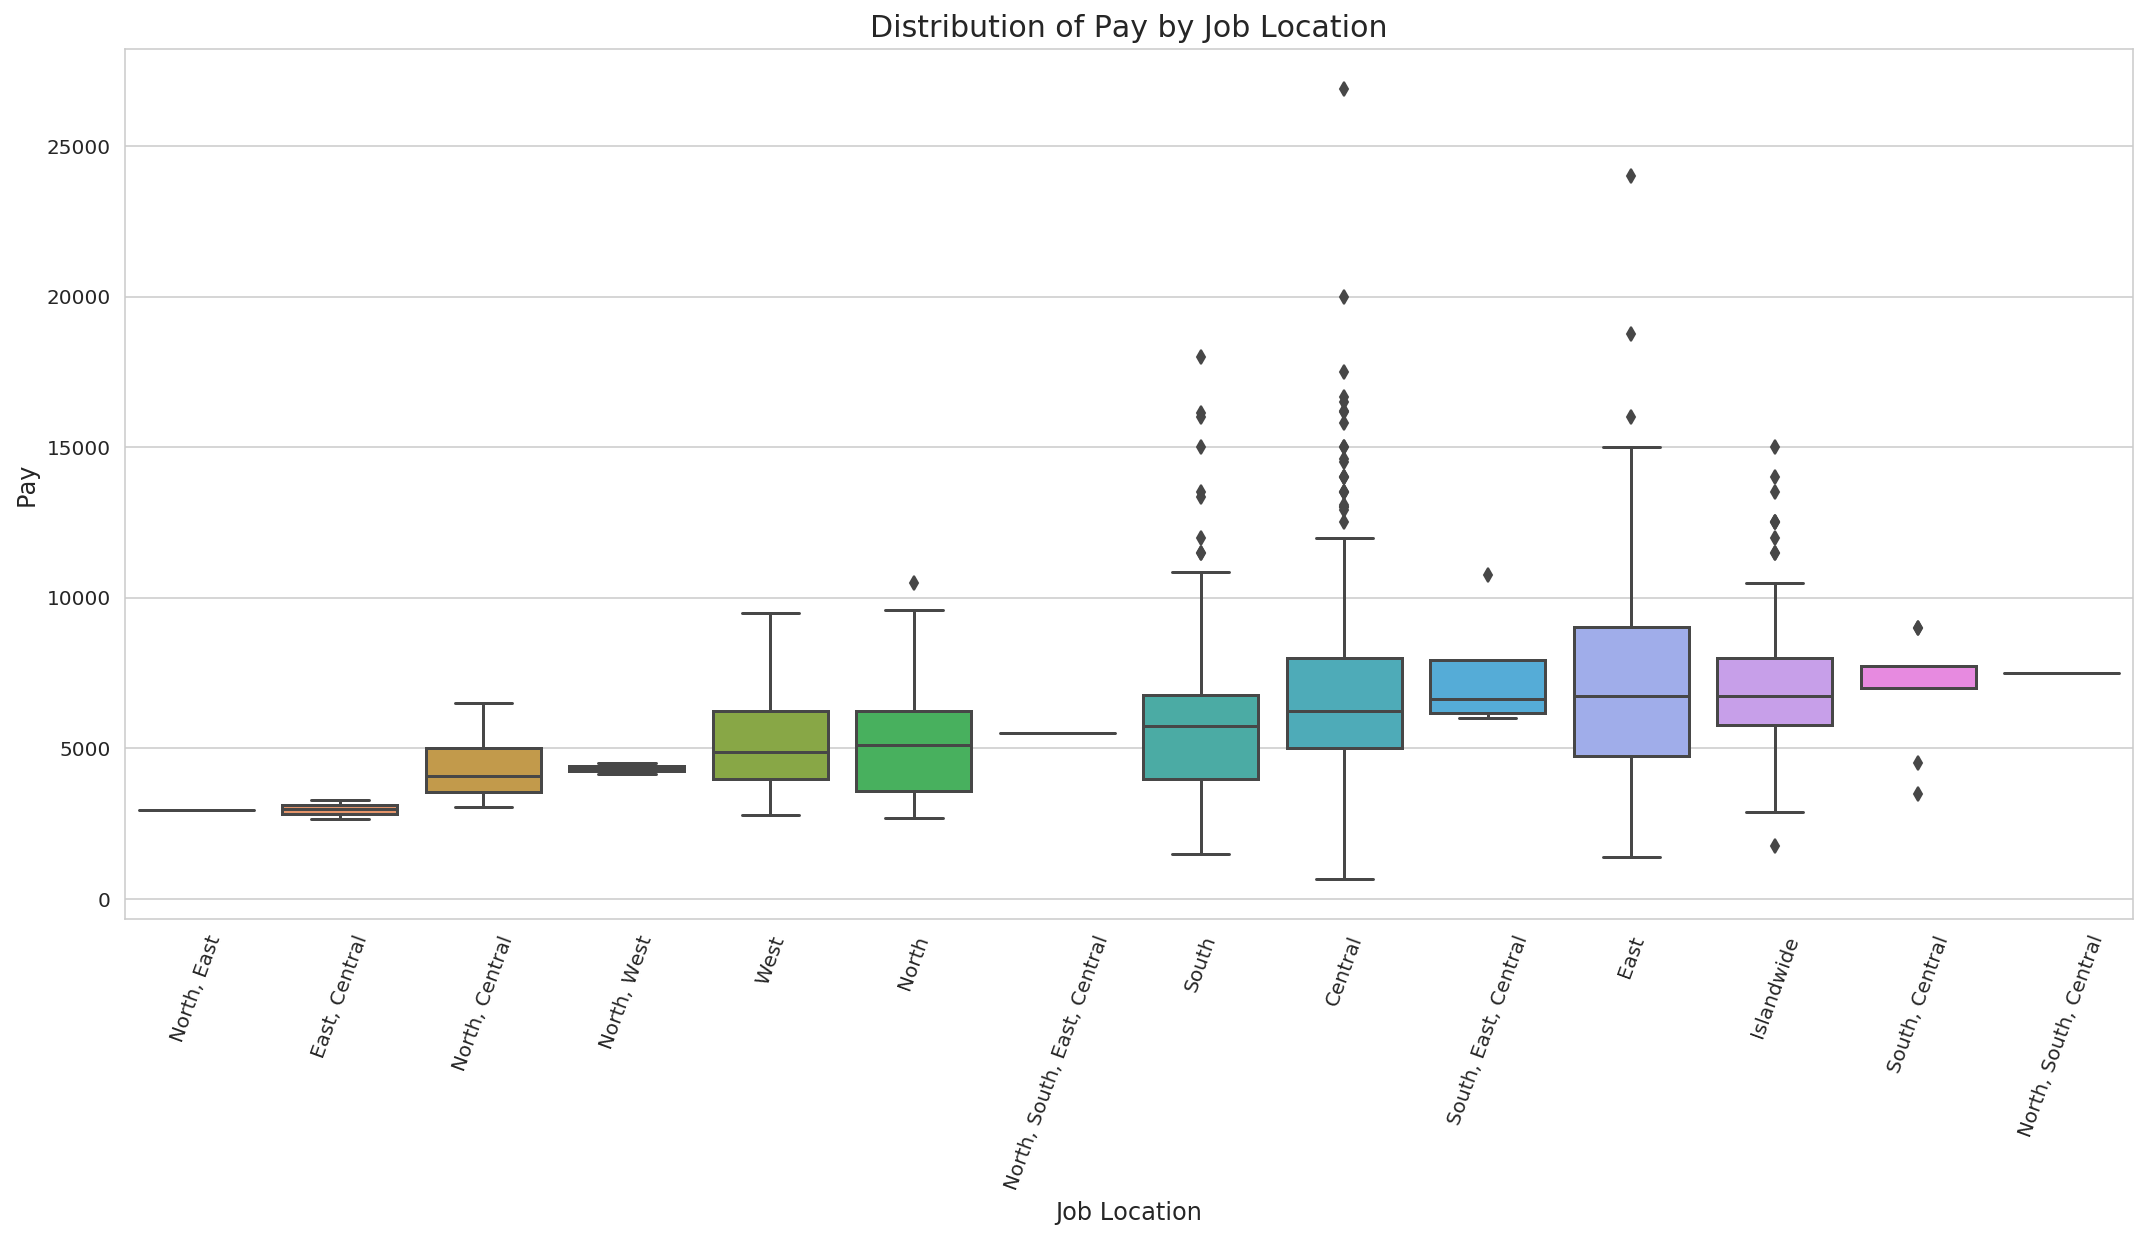

In [35]:
# Let's look at distribution of pay by job location
fig, ax = plt.subplots(figsize=(18,8))

# Sort the boxplot in ascending mdeian pay
order = jobs.groupby(by='location')['pay'].median().sort_values().index

ax = sns.boxplot(data=jobs, x='location', y='pay', order=order, ax=ax)

# Set the x-y label parameters
ax.set_xlabel('Job Location', fontsize=12)
ax.set_ylabel('Pay', fontsize=12)

# Rotate the x-ticks labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)

# Set the plot title
ax.set_title('Distribution of Pay by Job Location', fontsize=15)

plt.show()

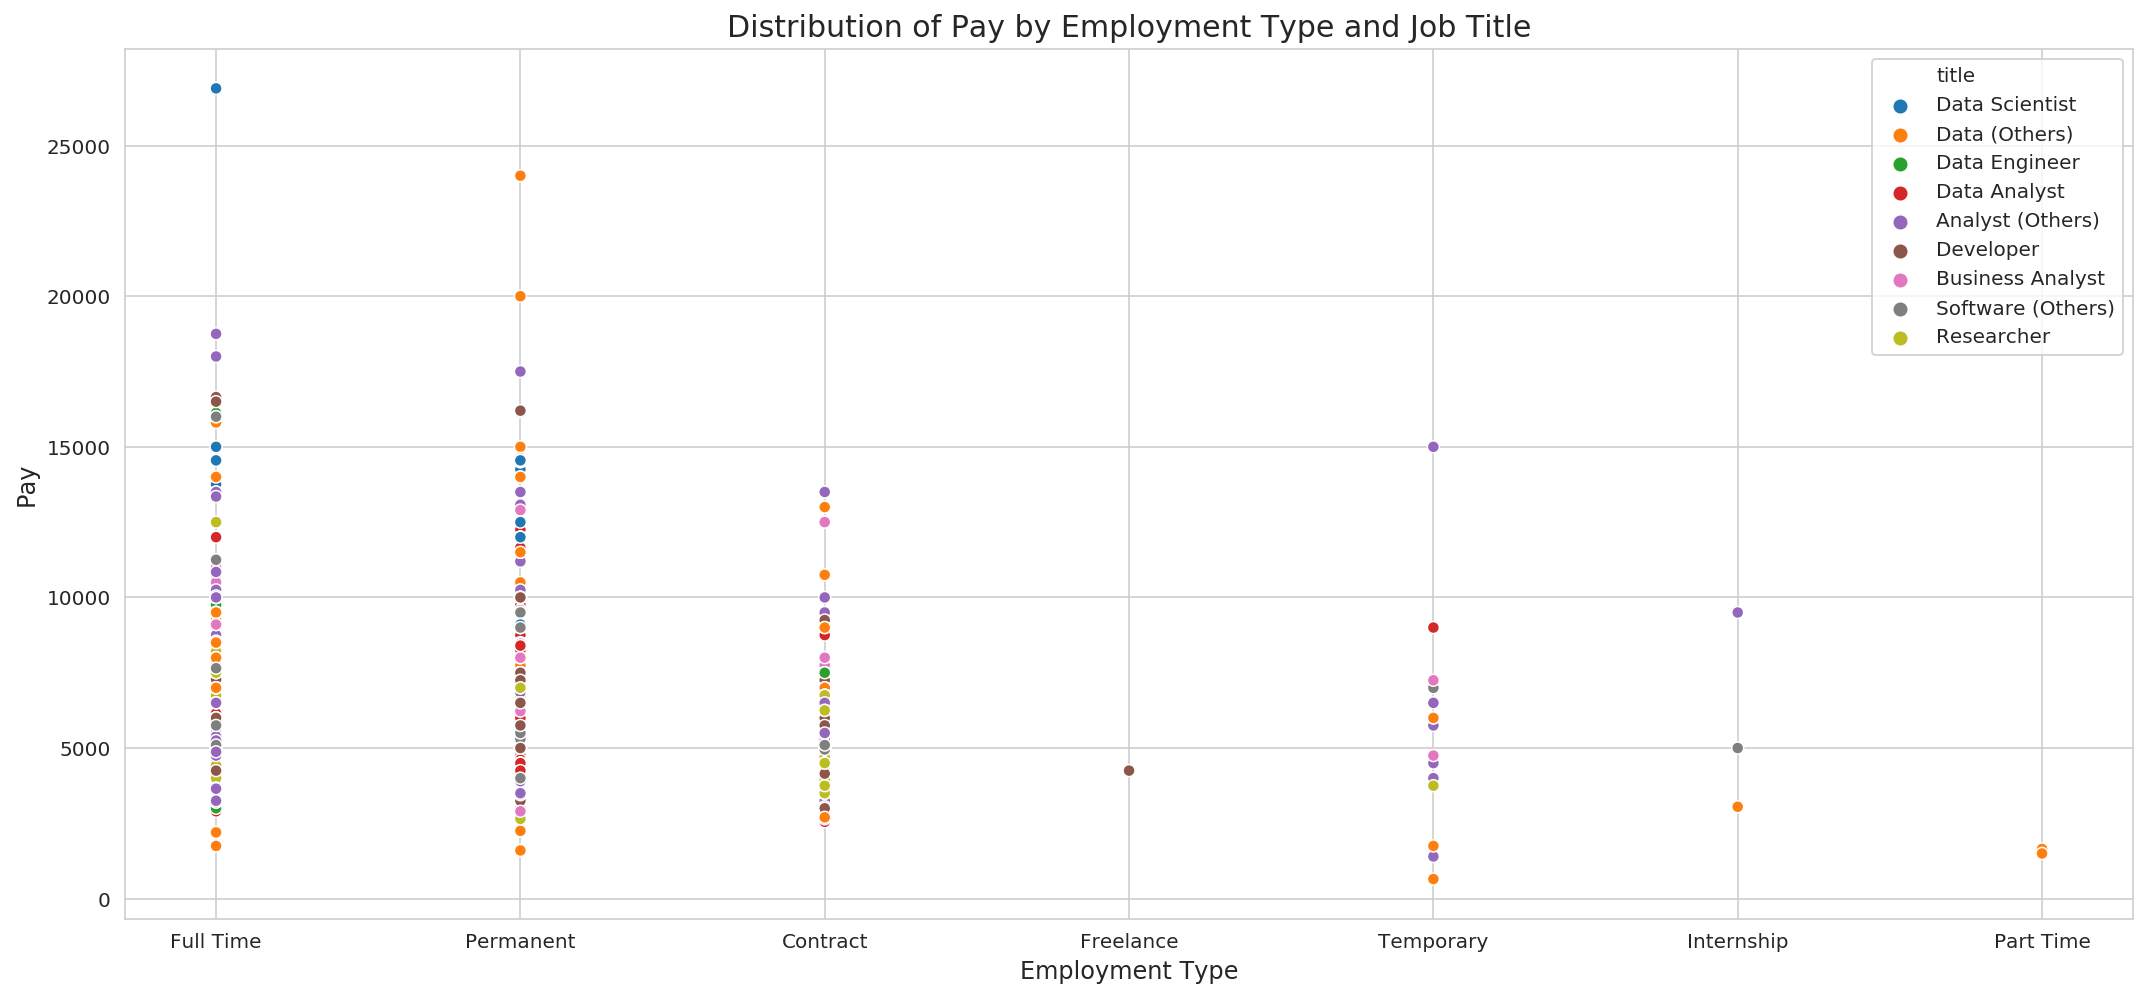

In [36]:
# Distribution of pay by seniority and title
fig, ax = plt.subplots(figsize=(18,8))

ax = sns.scatterplot(data=jobs, x='employment_type', y='pay', hue='title', ax=ax)

# Set the x-y label parameters
ax.set_xlabel('Employment Type', fontsize=12)
ax.set_ylabel('Pay', fontsize=12)

# Set the plot title
ax.set_title('Distribution of Pay by Employment Type and Job Title', fontsize=15)

plt.show()

#### 2.2 Train Test Split

In [37]:
# We will use all features except employer, company profile ('about'), and job_title as predictors.
# We will also combine the Roles & Responsibilities and Requirements columns to perform NLP as one.

jobs['description'] = jobs['rr'] + jobs['requirements']

X = jobs[['location', 'employment_type', 'seniority', 'sector', 'description', 'title']]
y = jobs['pay']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 2.3 Convert the description column to word tokens and get_dummy the other columns

In [39]:
# Use CountVectorizer to vectorize description column.
# min_df=2 to remove any word that appears only in 1 listing.
vect = CountVectorizer(stop_words='english', min_df=2)

# Vectorize description column
X_train_vect = pd.DataFrame(vect.fit_transform(X_train['description']).todense(), columns=vect.get_feature_names())

In [40]:
X_train_vect.shape

(657, 5449)

In [41]:
# Most frequent words
X_train_vect.sum(axis=0).sort_values(ascending=False)[:10]

data           3564
experience     2109
business       1405
skills         1081
work           1074
team           1044
management      891
development     810
knowledge       775
design          689
dtype: int64

In [42]:
# Least frequent words
X_train_vect.sum(axis=0).sort_values(ascending=True)[:10]

iterating       2
databricks      2
proofs          2
propositions    2
cytometry       2
prospect        2
prospective     2
cvmd            2
protects        2
provisioning    2
dtype: int64

In [43]:
# Dummy code the rest of the columns
X_train_dummy = pd.get_dummies(X_train[['location', 'employment_type', 'seniority', 'sector', 'title']]).reset_index(drop=True)

In [44]:
X_train_dummy.shape

(657, 64)

In [45]:
# Concatenate X_train_vect and X_train_dummy
X_train_trf = pd.concat([X_train_vect, X_train_dummy], axis=1)

In [46]:
X_train_trf.shape

(657, 5513)

In [47]:
# Perform the same transformation on X_test

# Vectorize description column
X_test_vect = pd.DataFrame(vect.transform(X_test['description']).todense(), columns=vect.get_feature_names())

# Dummy code the rest of the columns
X_test_dummy = pd.get_dummies(X_test[['location', 'employment_type', 'seniority', 'sector', 'title']]).reset_index(drop=True)

# Concatenate X_test_vect and X_test_dummy
X_test_trf = pd.concat([X_test_vect, X_test_dummy], axis=1)

In [48]:
X_train_trf.shape

(657, 5513)

In [49]:
X_test_trf.shape

(282, 5502)

In [50]:
# Check what are the missing columns in X_test_trf
missing_tst = list(X_train_trf.columns.values[np.isin(X_train_trf.columns.values, X_test_trf.columns.values, invert=True)])

#Add those missing columns to X_test_trf
X_test_trf = X_test_trf.reindex(columns= list(X_test_trf.columns.values)+missing_tst, fill_value=0)

In [51]:
# Check what are the missing columns in X_train_trf
missing_trn = list(X_test_trf.columns.values[np.isin(X_test_trf.columns.values, X_train_trf.columns.values, invert=True)])

# Add those missing columns to X_train_trf
X_train_trf = X_train_trf.reindex(columns= list(X_train_trf.columns.values)+missing_trn, fill_value=0)

In [52]:
print (X_train_trf.shape, X_test_trf.shape)

(657, 5517) (282, 5517)


#### 2.4 PCA + Ridge Regression

In [53]:
# Fit and Transform PCA on X_train and X_test
pca = PCA(n_components = 5)
X_train_pca = pca.fit_transform(X_train_trf)
X_test_pca = pca.transform(X_test_trf)

In [54]:
# Eigenvalues and Explained Variance
exp_var_eigenvals = pca.explained_variance_
exp_var_pct = pca.explained_variance_ratio_

print('')
for i in range(len(exp_var_eigenvals)):
    print(exp_var_eigenvals[i], exp_var_pct[i])

print('eigenvalues: {}'.format(np.round(exp_var_eigenvals,2)))
print('explained variance %: {}'.format(np.round(exp_var_pct,2)))


49.51385604819815 0.12230584420824636
21.769170509470282 0.05377276159389153
11.64911973883524 0.028774883187330316
9.279516993650226 0.022921647602004137
8.809705549433126 0.02176115052321201
eigenvalues: [49.51 21.77 11.65  9.28  8.81]
explained variance %: [0.12 0.05 0.03 0.02 0.02]


##### The 5 principal components covers only approx. 20% of the original data variance

In [55]:
# Ridge Regression 

ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_pca, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_cv_scores = cross_val_score(ridge, X_train_pca, y_train, cv=10)
ridge_mean_cv_score = np.mean(ridge_cv_scores)
ridge_std_cv_score = np.std(ridge_cv_scores)

ridge_model = ridge.fit(X_train_pca, y_train)
ridge_test_score = ridge_model.score(X_test_pca, y_test)
ridge_mse = mean_squared_error(y_test, ridge_model.predict(X_test_pca))

print("CV scores: {}" .format(ridge_cv_scores))
print("Mean CV score: {}" .format(ridge_mean_cv_score))
print("CV Score STD: {}" .format(ridge_std_cv_score))
print("Score on Test Set: {}" .format(ridge_test_score))
print("Mean Squared Error: {}" .format(ridge_mse))

CV scores: [ 0.00186123  0.03915637  0.33873486  0.20785972 -0.09329049  0.26468871
  0.27001972  0.18548343 -0.12071576  0.19383401]
Mean CV score: 0.1287631799193584
CV Score STD: 0.15228459580113043
Score on Test Set: 0.20110923467584552
Mean Squared Error: 6223128.404458546


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### 2.5 Random Forest Regression

In [56]:
"""
Commenting this section out so that it doesn't run on every kernel restart

rf_params = {
    'max_depth':range(5,21),
    'n_estimators':range(5,21),
    'min_samples_split':range(2,20,5)
}

rf_gs = GridSearchCV(RandomForestRegressor(), 
                      rf_params, 
                      cv=5, 
                      verbose=1, 
                      scoring=None, 
                      n_jobs=-1)

rf_gs.fit(X_train_trf, y_train)
rf_best = rf_gs.best_estimator_

print("best parameters: {}" .format(rf_gs.best_params_))
print("best train score: {}" .format(rf_gs.best_score_))


Best parameters found {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 14}
"""

'\nCommenting this section out so that it doesn\'t run on every kernel restart\n\nrf_params = {\n    \'max_depth\':range(5,21),\n    \'n_estimators\':range(5,21),\n    \'min_samples_split\':range(2,20,5)\n}\n\nrf_gs = GridSearchCV(RandomForestRegressor(), \n                      rf_params, \n                      cv=5, \n                      verbose=1, \n                      scoring=None, \n                      n_jobs=-1)\n\nrf_gs.fit(X_train_trf, y_train)\nrf_best = rf_gs.best_estimator_\n\nprint("best parameters: {}" .format(rf_gs.best_params_))\nprint("best train score: {}" .format(rf_gs.best_score_))\n\n\nBest parameters found {\'max_depth\': 16, \'min_samples_split\': 2, \'n_estimators\': 14}\n'

In [57]:
# Using the best paramaters from the GridSearch.

rf = RandomForestRegressor(max_depth=16, n_estimators=14, min_samples_split=2, random_state=1)

rf.fit(X_train_trf, y_train)
rf_cv_scores = cross_val_score(rf, X_train_trf, y_train, cv=10, n_jobs=-1)
rf_mean_cv_score = np.mean(rf_cv_scores)
rf_std_cv_score = np.std(rf_cv_scores)

rf_test_score = rf.score(X_test_trf, y_test)
rf_mse = mean_squared_error(y_test, rf.predict(X_test_trf))

print("CV scores: {}" .format(rf_cv_scores))
print("Mean CV score: {}" .format(rf_mean_cv_score))
print("CV Score STD: {}" .format(rf_std_cv_score))
print("Score on Test Set: {}" .format(rf_test_score))
print("Mean Squared Error: {}" .format(rf_mse))

CV scores: [0.14779094 0.33056621 0.49279932 0.39268768 0.19323763 0.22198457
 0.50654026 0.36279237 0.01429349 0.30786153]
Mean CV score: 0.2970553977975551
CV Score STD: 0.14681762644894428
Score on Test Set: 0.30329207034295735
Mean Squared Error: 5427153.617054282


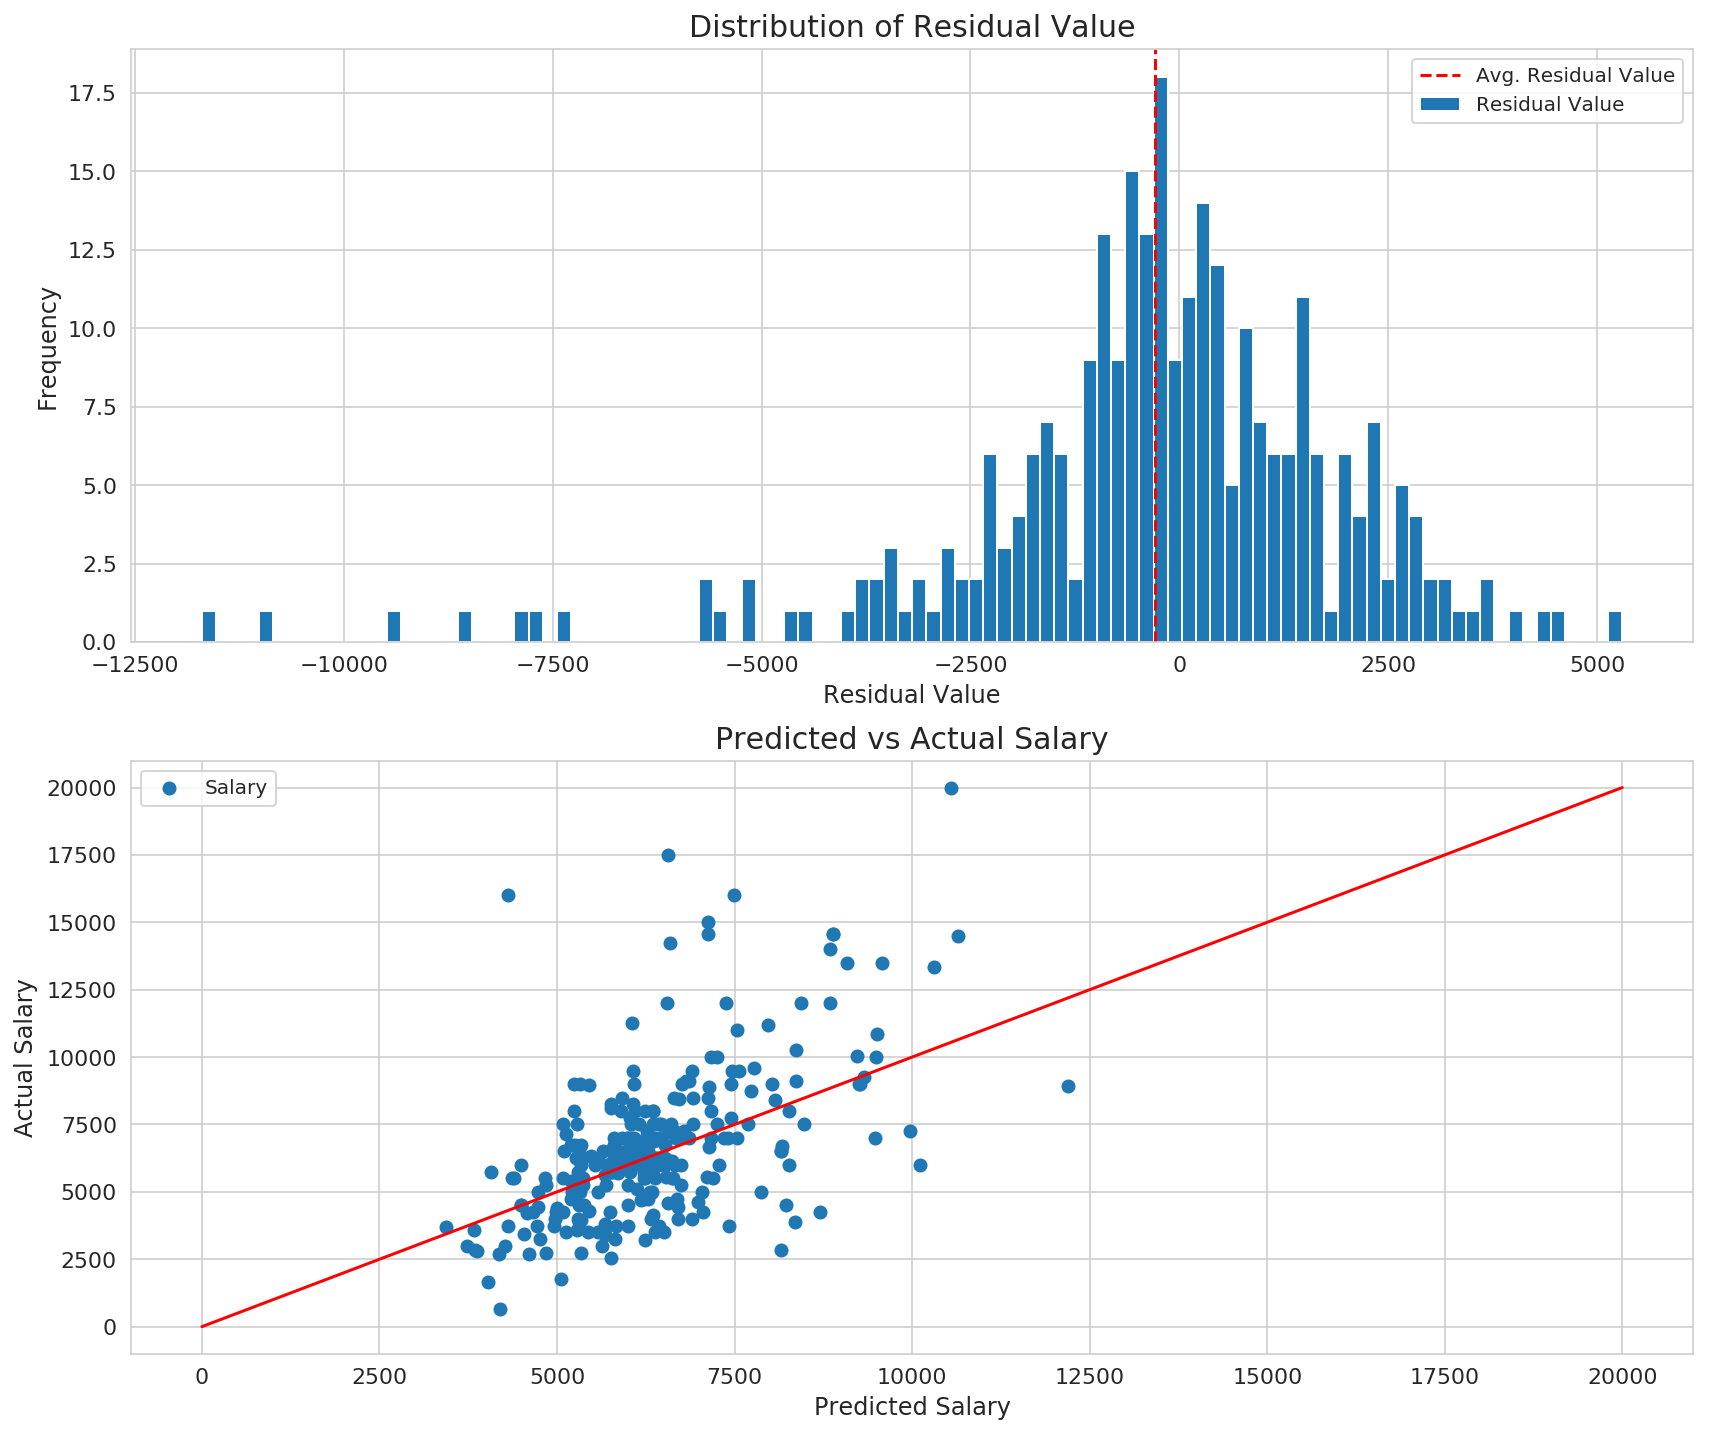

In [58]:
# Residual plot
y_hat = rf.predict(X_test_trf)
residual = y_hat - y_test

# Distribution plot of Prediction Residual
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,12))

ax[0].hist(x=residual, bins=100, label='Residual Value')
ax[0].axvline(np.mean(residual), color='r', linestyle='--', label='Avg. Residual Value')

ax[0].set_xlabel('Residual Value', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12)
ax[0].set_title('Distribution of Residual Value', fontsize=15)

ax[0].tick_params(axis='both', labelsize=11)

ax[0].legend()


# Scatter Plot of Prediction vs Actual

ax[1].scatter(x=y_hat, y=y_test, label='Salary')
ax[1].plot((0,y_test.max()), (0,y_test.max()), c='red')

ax[1].set_xlabel('Predicted Salary', fontsize=12)
ax[1].set_ylabel('Actual Salary', fontsize=12)
ax[1].set_title('Predicted vs Actual Salary', fontsize=15)

ax[1].tick_params(axis='both', labelsize=11)

ax[1].legend(loc='upper left')

plt.show()

In [59]:
# Feature Importance
pd.Series(data=rf.feature_importances_, index=X_train_trf.columns.values).sort_values(ascending=False)[:10]

commodities     0.035607
strategy        0.032652
experience      0.025963
business        0.025759
teams           0.025296
diploma         0.022674
strategic       0.017773
organization    0.015713
creed           0.015285
needs           0.014017
dtype: float64

#### Summary: 
1. The R2 score for the first model of (PCA + Ridge Regression) is quite low 0.17. This is as expected as the 5 PCA components that we used covers only 20% of the original data varaince. We lost 80% of the original variance after the PCA. Hence, the R2 score was expected to be low.

2. The R2 score for the Random Forest model using all features is slightly better at 0.32 on the test set. The  standard deviation (0.16) of the Cross Validated score might suggest some overfitting of the model. 

3. Based on the feature importance returned from the model, the top 5 features determining pay are: 
    - Seniority: this makes sense as the higher the seniority, the higher would be the pay
    - Diploma: This is a little odd as we would think degree or post-degree will fetch higher pay
    - Leadership: Seems like in terms of soft-skills, employers value people with leadership qualities and would pay more for this trait.
    - Customer: Not too sure just by looking at this one word. Perhaps customer focused? This is where using  ngrams > 1 would be useful to provide the full context.
    - Strategy: Makes sense. People in higher seniority positions are mostly required to formulate strategy. Hence, strategy could appear frequently with seniority and hence command a higher pay.
    
    
4. Possible improvements to the model:
    - Features can be cleaned/ trimmed further by running spell check and stemming prior to tokenization.
    - Add additional features sure as Parts of Speech (POS)
    - Add additional feature sure as TF-IDF

<font color='blue'>

### 3.0 QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
    - What components of a job posting distinguish data scientists from other data jobs?
    - What features are important for distinguishing junior vs. senior positions?
    - Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

### 3.1 Components Distinguishing Data Scientist from Other Jobs

In [60]:
# Let's use the other features to predict whether or not a job falls into the Data Scientist category

# Create a new target column where Data Scientist = 1, the rest = 0
y = np.where(jobs['title']=='Data Scientist',1, 0)

# Create new predictor matrix
X = jobs[['location', 'employment_type', 'seniority', 'sector', 'description', 'pay']]

In [61]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 3.1.1 Convert the description column to word tokens and get_dummy the other columns

In [62]:
# Use CountVectorizer to vectorize description column.
# min_df=2 to remove any word that appears only in 1 listing.
vect = CountVectorizer(stop_words='english', min_df=2)

# Vectorize description column
X_train_vect = pd.DataFrame(vect.fit_transform(X_train['description']).todense(), columns=vect.get_feature_names())

In [63]:
X_train_vect.shape

(657, 5468)

In [64]:
# Most frequent words
X_train_vect.sum(axis=0).sort_values(ascending=False)[:10]

data           3528
experience     2085
business       1404
skills         1093
work           1085
team           1014
management      877
knowledge       801
development     799
design          702
dtype: int64

In [65]:
# Least frequent words
X_train_vect.sum(axis=0).sort_values(ascending=True)[:10]

correlations     2
showcase         2
notebook         2
north            2
norms            2
clarification    2
enovia           2
citygml          2
citpm            2
enrichment       2
dtype: int64

In [66]:
# Dummy code the rest of the columns
X_train_dummy = pd.get_dummies(X_train[['location', 'employment_type', 'seniority', 'sector']]).reset_index(drop=True)

In [67]:
X_train_dummy.shape

(657, 56)

In [68]:
# Concatenate X_train_vect and X_train_dummy
X_train_trf = pd.concat([X_train_vect, X_train_dummy], axis=1)

In [69]:
X_train_trf.shape

(657, 5524)

In [70]:
# Perform the same transformation on X_test

# Vectorize description column
X_test_vect = pd.DataFrame(vect.transform(X_test['description']).todense(), columns=vect.get_feature_names())

# Dummy code the rest of the columns
X_test_dummy = pd.get_dummies(X_test[['location', 'employment_type', 'seniority', 'sector']]).reset_index(drop=True)

# Concatenate X_test_vect and X_test_dummy
X_test_trf = pd.concat([X_test_vect, X_test_dummy], axis=1)

In [71]:
X_train_trf.shape

(657, 5524)

In [72]:
X_test_trf.shape

(282, 5514)

In [73]:
# Check what are the missing columns in X_test_trf
missing_tst = list(X_train_trf.columns.values[np.isin(X_train_trf.columns.values, X_test_trf.columns.values, invert=True)])

#Add those missing columns to X_test_trf
X_test_trf = X_test_trf.reindex(columns= list(X_test_trf.columns.values)+missing_tst, fill_value=0)

In [74]:
# Check what are the missing columns in X_train_trf
missing_trn = list(X_test_trf.columns.values[np.isin(X_test_trf.columns.values, X_train_trf.columns.values, invert=True)])

# Add those missing columns to X_train_trf
X_train_trf = X_train_trf.reindex(columns= list(X_train_trf.columns.values)+missing_trn, fill_value=0)

In [75]:
print (X_train_trf.shape, X_test_trf.shape)

(657, 5527) (282, 5527)


#### 3.1.2 Use Naive Bayes to predict the traget category

In [76]:
# We will be using the MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_trf, y_train)

nb_cv_scores = cross_val_score(nb, X_train_trf, y_train, cv=5)
nb_mean_cv_score = np.mean(nb_cv_scores)
nb_std_cv_score = np.std(nb_cv_scores)

nb_test_score = nb.score(X_test_trf, y_test)
nb_baseline = max(np.mean(y_test), 1-np.mean(y_test))

# Calculate AUC Score
fpr, tpr, _ = roc_curve(y_test, nb.predict_proba(X_test_trf)[:,1])
roc_auc = auc(fpr, tpr)

print("CV scores: {}" .format(nb_cv_scores))
print("Mean CV score: {}" .format(nb_mean_cv_score))
print("CV Score STD: {}" .format(nb_std_cv_score))
print("Score on Test Set: {}" .format(nb_test_score))
print("Test Set Baseline: {}" .format(nb_baseline))
print("AUC Score: {}" .format(roc_auc))

CV scores: [0.97727273 0.92424242 0.9469697  0.97709924 0.94615385]
Mean CV score: 0.9543475862559833
CV Score STD: 0.020352351672150375
Score on Test Set: 0.9539007092198581
Test Set Baseline: 0.8936170212765957
AUC Score: 0.9592592592592593


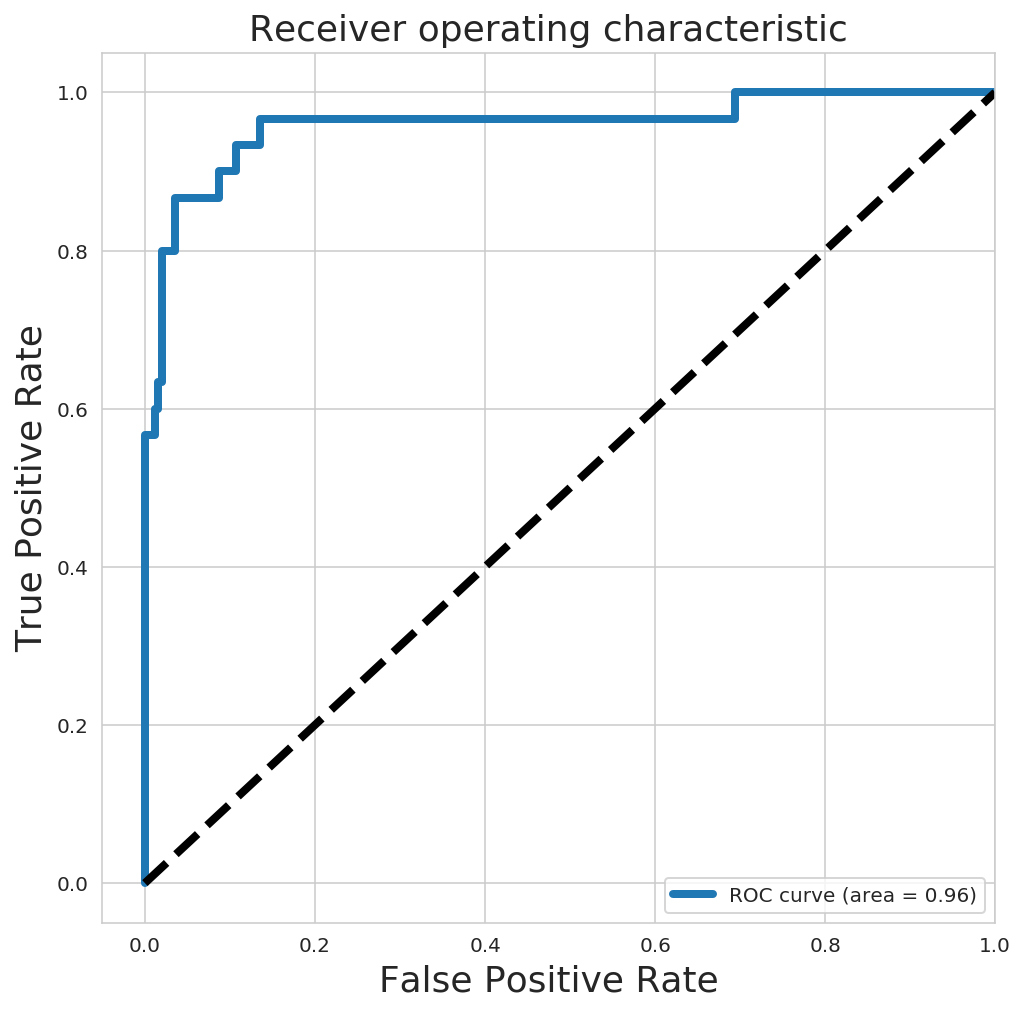

In [77]:
#Plot ROC Curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [78]:
# Classification Report
print(classification_report(y_test, nb.predict(X_test_trf)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       252
           1       0.81      0.73      0.77        30

   micro avg       0.95      0.95      0.95       282
   macro avg       0.89      0.86      0.87       282
weighted avg       0.95      0.95      0.95       282



In [79]:
# Confusion Matrix

conmat = np.array(confusion_matrix(y_test, nb.predict(X_test_trf), labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Data Scientist', 'Others'],
                         columns=['Predicted Data Scientist','Predicted Others'])

confusion

,Predicted Data Scientist,Predicted Others
Data Scientist,22,8
Others,5,247


In [80]:
# Let's look at what are the features with the highest probability given a prediction of 'Data Scientist' or Others

Data_science_class = np.exp(nb.feature_log_prob_[1])
Other_class = np.exp(nb.feature_log_prob_[0])

# Make a dataframe with the probabilities and features
feat_probs = pd.DataFrame({'Data Scientist':Data_science_class, 'Others':Other_class, 'feature':X_train_trf.columns.values})
feat_probs['Data Science Diff'] = feat_probs['Data Scientist'] - feat_probs['Others']

feat_probs.sort_values('Data Science Diff', ascending=False, inplace=True)
feat_probs.head(10)

,Data Scientist,Others,feature,Data Science Diff
2870,0.010455,0.001747,learning,0.008708
1333,0.030270,0.023861,data,0.006409
2990,0.007476,0.001149,machine,0.006327
319,0.007659,0.003038,analytics,0.004621
4382,0.005957,0.002707,science,0.003250
3217,0.004437,0.001243,models,0.003194
4731,0.003221,0.000803,statistical,0.002419
1377,0.003161,0.000779,deep,0.002382
3761,0.002249,0.000260,predictive,0.001989
4733,0.002614,0.000708,statistics,0.001905


#### Summary: 
1. As shown in the Probability Table above, the main keywords ('features') that distinguishes whether a job is in the Data Scientist category or not are: learning, machine, data, scince and models.

2. These keywords importance fit our understanding that a data scientist job requires, machine learning, and creating models.

### 3.2 Features Distinguishing Junior vs Senior Positions

In [81]:
# Let's have a look at the different seniority levels
jobs.seniority.value_counts()

Professional         273
Executive            227
Senior Executive     118
Non-executive         84
Manager               78
Junior Executive      45
Middle Management     44
Fresh/entry level     41
Senior Management     29
Name: seniority, dtype: int64

In [82]:
# Define Senior and Junior Positions
senior = ['Professional', 'Senior Executive', 'Manager', 'Middle Management', 'Senior Management']
junior = [x for x in jobs.seniority.value_counts().index if x not in senior]

In [83]:
# Let's use the other features to predict whether or not a a listing is for Junior or Senior Position

# Create a new target column where Senior = 1, Junior = 0
y = jobs['seniority'].map(lambda x: 1 if x in senior else 0)

# Create new predictor matrix
X = jobs[['location', 'employment_type', 'title', 'sector', 'description', 'pay']]

In [84]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### 3.2.1 Convert the description column to word tokens and get_dummy the other columns

In [85]:
# Use CountVectorizer to vectorize description column.
# min_df=3 to remove any word that appears only in 2 listing.
vect = CountVectorizer(stop_words='english', min_df=4, ngram_range=(1,2))

# Vectorize description column
X_train_vect = pd.DataFrame(vect.fit_transform(X_train['description']).todense(), columns=vect.get_feature_names())

In [86]:
X_train_vect.shape

(657, 7813)

In [87]:
# Most frequent words
X_train_vect.sum(axis=0).sort_values(ascending=False)[:10]

data           3560
experience     2164
business       1304
work           1080
skills         1028
team           1025
management      869
knowledge       803
development     793
design          665
dtype: int64

In [88]:
# Least frequent words
X_train_vect.sum(axis=0).sort_values(ascending=True)[:10]

zealand singapore     4
externally            4
life job              4
tactical planning     4
methodical            4
life data             4
process applicable    4
continuity            4
continued growth      4
life company          4
dtype: int64

In [89]:
# Dummy code the rest of the columns
X_train_dummy = pd.get_dummies(X_train[['location', 'employment_type', 'title', 'sector']]).reset_index(drop=True)

In [90]:
X_train_dummy.shape

(657, 56)

In [91]:
# Concatenate X_train_vect and X_train_dummy
X_train_trf = pd.concat([X_train_vect, X_train_dummy], axis=1)

In [92]:
X_train_trf.shape

(657, 7869)

In [93]:
# Perform the same transformation on X_test

# Vectorize description column
X_test_vect = pd.DataFrame(vect.transform(X_test['description']).todense(), columns=vect.get_feature_names())

# Dummy code the rest of the columns
X_test_dummy = pd.get_dummies(X_test[['location', 'employment_type', 'title', 'sector']]).reset_index(drop=True)

# Concatenate X_test_vect and X_test_dummy
X_test_trf = pd.concat([X_test_vect, X_test_dummy], axis=1)

In [94]:
X_train_trf.shape

(657, 7869)

In [95]:
X_test_trf.shape

(282, 7859)

In [96]:
# Check what are the missing columns in X_test_trf
missing_tst = list(X_train_trf.columns.values[np.isin(X_train_trf.columns.values, X_test_trf.columns.values, invert=True)])

#Add those missing columns to X_test_trf
X_test_trf = X_test_trf.reindex(columns= list(X_test_trf.columns.values)+missing_tst, fill_value=0)

In [97]:
# Check what are the missing columns in X_train_trf
missing_trn = list(X_test_trf.columns.values[np.isin(X_test_trf.columns.values, X_train_trf.columns.values, invert=True)])

# Add those missing columns to X_train_trf
X_train_trf = X_train_trf.reindex(columns= list(X_train_trf.columns.values)+missing_trn, fill_value=0)

In [98]:
print (X_train_trf.shape, X_test_trf.shape)

(657, 7872) (282, 7872)


#### 3.2.2 Use Random Forest Classification to predict the target

In [99]:
"""
Commenting this section out as it takes a long time to run.

rf_params = {
    'max_depth':range(5,21),
    'n_estimators':range(5,21),
    'min_samples_split':range(2,20,5)
}

rf_gs = GridSearchCV(RandomForestClassifier(), 
                      rf_params, 
                      cv=5, 
                      verbose=1, 
                      scoring=None, 
                      n_jobs=-1)

rf_gs.fit(X_train_trf, y_train)
rf_best = rf_gs.best_estimator_

print("best parameters: {}" .format(rf_gs.best_params_))
print("best train score: {}" .format(rf_gs.best_score_))


best parameters: {'max_depth': 20, 'min_samples_split': 7, 'n_estimators': 17} used in the model below.
"""

'\nCommenting this section out as it takes a long time to run.\n\nrf_params = {\n    \'max_depth\':range(5,21),\n    \'n_estimators\':range(5,21),\n    \'min_samples_split\':range(2,20,5)\n}\n\nrf_gs = GridSearchCV(RandomForestClassifier(), \n                      rf_params, \n                      cv=5, \n                      verbose=1, \n                      scoring=None, \n                      n_jobs=-1)\n\nrf_gs.fit(X_train_trf, y_train)\nrf_best = rf_gs.best_estimator_\n\nprint("best parameters: {}" .format(rf_gs.best_params_))\nprint("best train score: {}" .format(rf_gs.best_score_))\n\n\nbest parameters: {\'max_depth\': 20, \'min_samples_split\': 7, \'n_estimators\': 17} used in the model below.\n'

In [100]:
# Using the best paramaters from the GridSearch.

rf = RandomForestClassifier(max_depth=20, n_estimators=17, min_samples_split=7, random_state=1)

rf.fit(X_train_trf, y_train)
rf_cv_scores = cross_val_score(rf, X_train_trf, y_train, cv=10, n_jobs=-1)
rf_mean_cv_score = np.mean(rf_cv_scores)
rf_std_cv_score = np.std(rf_cv_scores)

rf_test_score = rf.score(X_test_trf, y_test)
rf_baseline = max(np.mean(y_test), 1-np.mean(y_test))

# Calculate AUC Score
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test_trf)[:,1])
roc_auc = auc(fpr, tpr)

print("CV scores: {}" .format(rf_cv_scores))
print("Mean CV score: {}" .format(rf_mean_cv_score))
print("CV Score STD: {}" .format(rf_std_cv_score))
print("Score on Test Set: {}" .format(rf_test_score))
print("Test Set Baseline: {}" .format(rf_baseline))
print("AUC Score: {}" .format(roc_auc))

/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CV scores: [0.65671642 0.62686567 0.63636364 0.66666667 0.66666667 0.67692308
 0.63076923 0.72307692 0.66153846 0.73846154]
Mean CV score: 0.6684048290018441
CV Score STD: 0.035111148094730704
Score on Test Set: 0.7340425531914894
Test Set Baseline: 0.5921985815602837
AUC Score: 0.7728716480083311


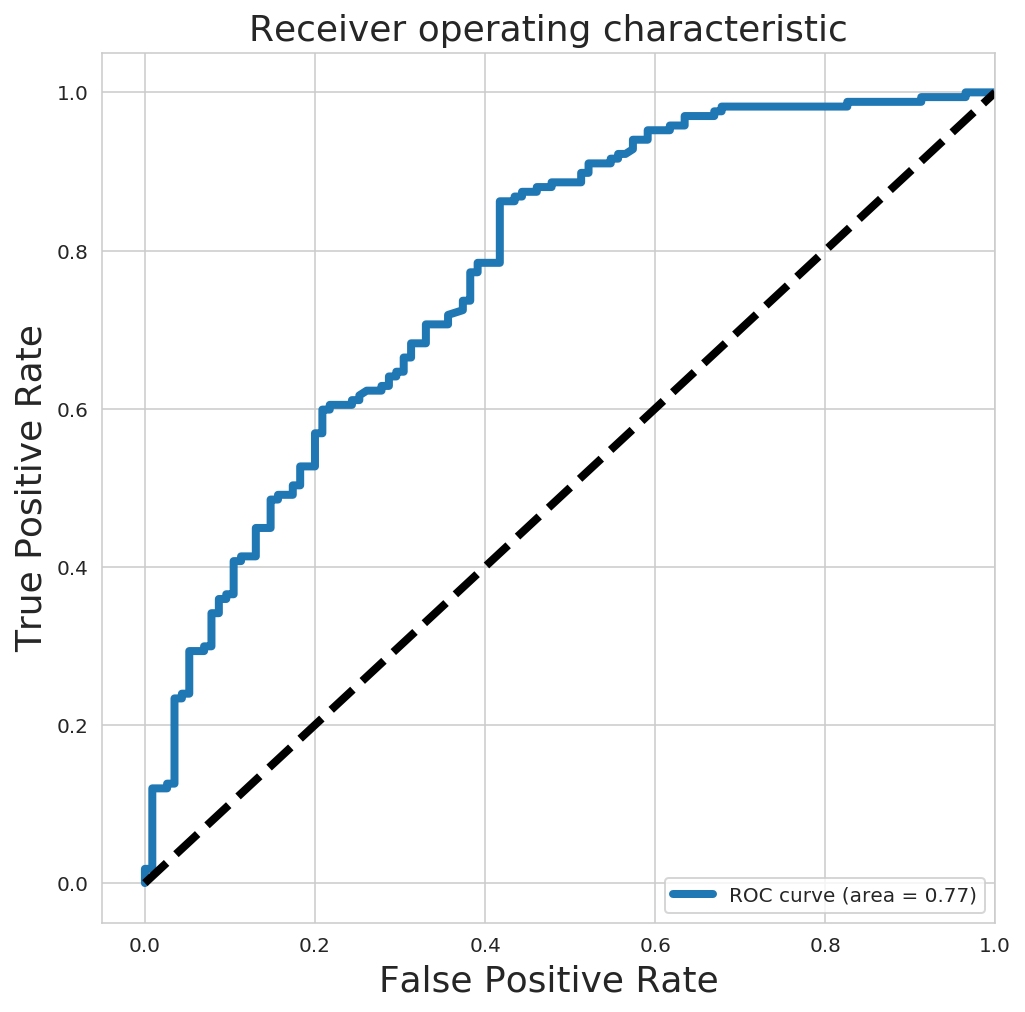

In [101]:
#Plot ROC Curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [102]:
# Classification Report
print(classification_report(y_test, rf.predict(X_test_trf)))

              precision    recall  f1-score   support

           0       0.79      0.48      0.59       115
           1       0.72      0.91      0.80       167

   micro avg       0.73      0.73      0.73       282
   macro avg       0.75      0.69      0.70       282
weighted avg       0.75      0.73      0.72       282



In [103]:
# Confusion Matrix

conmat = np.array(confusion_matrix(y_test, rf.predict(X_test_trf), labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Senior', 'Junior'],
                         columns=['Predicted Senior','Predicted junior'])

confusion

,Predicted Senior,Predicted junior
Senior,152,15
Junior,60,55


Observation: Our model is not good in predicting junior.

In [104]:
# Feature Importance
pd.Series(data=rf.feature_importances_, index=X_train_trf.columns.values).sort_values(ascending=False)[:20]

diploma                   0.015767
proficiency               0.007030
business                  0.006180
ms excel                  0.005835
molecular biology         0.005556
file                      0.005541
node                      0.004958
complex problems          0.004942
working experience        0.004853
strong                    0.004825
supports                  0.004477
subjects                  0.004345
pressure                  0.004228
publications              0.004211
star include              0.004129
data entry                0.004106
provide guidance          0.004097
collaboratively           0.004091
experience programming    0.003872
bank                      0.003758
dtype: float64

##### Summary: 
1. The accuracy of the model on the test set 0.65 is only slightly better than the baseline score of 0.59. Looking at the confusion matrix, the model has a tendency to predict Senior position rather than Junior, hence resulting in alot of False Junior predictions.

2. Based on the feature importance returned from the model, some of the features that we can relate to are: 
    - experience, lead, years (year of experience?).
    - Jobs falling into the Data Scientist category also tend to predict a more senior position.

3. Possible improvements to the model:
    - Features can be cleaned/ trimmed further by running spell check and stemming prior to tokenization. As it is 
      quite hard to make out the meaning of some of the important features.


### 3.3 Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

In [105]:
jobs.sector.value_counts().head(5)

Information Technology         444
Banking and Finance            102
Engineering                     93
Sciences / Laboratory / R&D     85
Others                          58
Name: sector, dtype: int64

In [106]:
# For this question, let's investigate if the there is any significant difference in the features
# in deciding seniority of the role (senior or junior) across different sectors.

# We will repeat what we did with Section 3.2, but this time running for two different sectors: 
# Information Technology vs Banking and Finance.

#### 3.3.1 Features distinguishing Seniority in Information Technology Sector

In [107]:
jobs_it = jobs[jobs.sector=='Information Technology']

In [108]:
# Let's use the other features to predict whether or not a a listing is for Junior or Senior Position

# Create a new target column where Senior = 1, Junior = 0
y = jobs_it['seniority'].map(lambda x: 1 if x in senior else 0)

# Create new predictor matrix
X = jobs_it[['location', 'employment_type', 'title', 'sector', 'description', 'pay']]

In [109]:
# Use CountVectorizer to vectorize description column.
# min_df=3 to remove any word that appears only in 2 listing.
vect = CountVectorizer(stop_words='english', min_df=3, ngram_range=(1,5))

# Vectorize description column
X_vect = pd.DataFrame(vect.fit_transform(X['description']).todense(), columns=vect.get_feature_names())

In [110]:
X_vect.shape

(444, 20246)

In [111]:
# Most frequent words
X_vect.sum(axis=0).sort_values(ascending=False)[:10]

data           2477
experience     1646
business        831
work            685
development     668
team            634
skills          622
design          596
management      564
knowledge       563
dtype: int64

In [112]:
# Least frequent words
X_vect.sum(axis=0).sort_values(ascending=True)[:10]

zookeeper                             3
reduction                             3
experience computer science           3
experience considered                 3
experience core                       3
experience core java                  3
redhat                                3
redundancy                            3
experience cross                      3
experience cross functional domain    3
dtype: int64

In [113]:
# Dummy code the rest of the columns
X_dummy = pd.get_dummies(X[['location', 'employment_type', 'title', 'sector']]).reset_index(drop=True)

In [114]:
X_dummy.shape

(444, 29)

In [115]:
# Concatenate X_train_vect and X_train_dummy
X_trf = pd.concat([X_vect, X_dummy], axis=1)

In [116]:
X_trf.shape

(444, 20275)

In [117]:
"""
Commenting this section out as it takes a long time to run.

rf_params = {
    'max_depth':range(5,21),
    'n_estimators':range(5,21),
    'min_samples_split':range(2,20,5)
}

rf_gs = GridSearchCV(RandomForestClassifier(), 
                      rf_params, 
                      cv=5, 
                      verbose=1, 
                      scoring=None, 
                      n_jobs=-1)

rf_gs.fit(X_trf, y)
rf_best = rf_gs.best_estimator_

print("best parameters: {}" .format(rf_gs.best_params_))
print("best train score: {}" .format(rf_gs.best_score_))


best parameters: {'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 17}
"""

'\nCommenting this section out as it takes a long time to run.\n\nrf_params = {\n    \'max_depth\':range(5,21),\n    \'n_estimators\':range(5,21),\n    \'min_samples_split\':range(2,20,5)\n}\n\nrf_gs = GridSearchCV(RandomForestClassifier(), \n                      rf_params, \n                      cv=5, \n                      verbose=1, \n                      scoring=None, \n                      n_jobs=-1)\n\nrf_gs.fit(X_trf, y)\nrf_best = rf_gs.best_estimator_\n\nprint("best parameters: {}" .format(rf_gs.best_params_))\nprint("best train score: {}" .format(rf_gs.best_score_))\n\n\nbest parameters: {\'max_depth\': 18, \'min_samples_split\': 2, \'n_estimators\': 17}\n'

In [118]:
# Using the best paramaters from the GridSearch.

rf = RandomForestClassifier(max_depth=18, n_estimators=17, min_samples_split=2, random_state=1)

rf.fit(X_trf, y)
rf_cv_scores = cross_val_score(rf, X_trf, y, cv=10, n_jobs=-1)
rf_mean_cv_score = np.mean(rf_cv_scores)
rf_std_cv_score = np.std(rf_cv_scores)

rf_baseline = max(np.mean(y), 1-np.mean(y))

# Calculate AUC Score
fpr, tpr, _ = roc_curve(y, rf.predict_proba(X_trf)[:,1])
roc_auc = auc(fpr, tpr)

print("CV scores: {}" .format(rf_cv_scores))
print("Mean CV score: {}" .format(rf_mean_cv_score))
print("CV Score STD: {}" .format(rf_std_cv_score))
print("Test Set Baseline: {}" .format(rf_baseline))
print("AUC Score: {}" .format(roc_auc))

CV scores: [0.58695652 0.63043478 0.65909091 0.61363636 0.56818182 0.56818182
 0.68181818 0.61363636 0.68181818 0.5       ]
Mean CV score: 0.6103754940711462
CV Score STD: 0.05412648062594559
Test Set Baseline: 0.5900900900900901
AUC Score: 0.9926600117439812


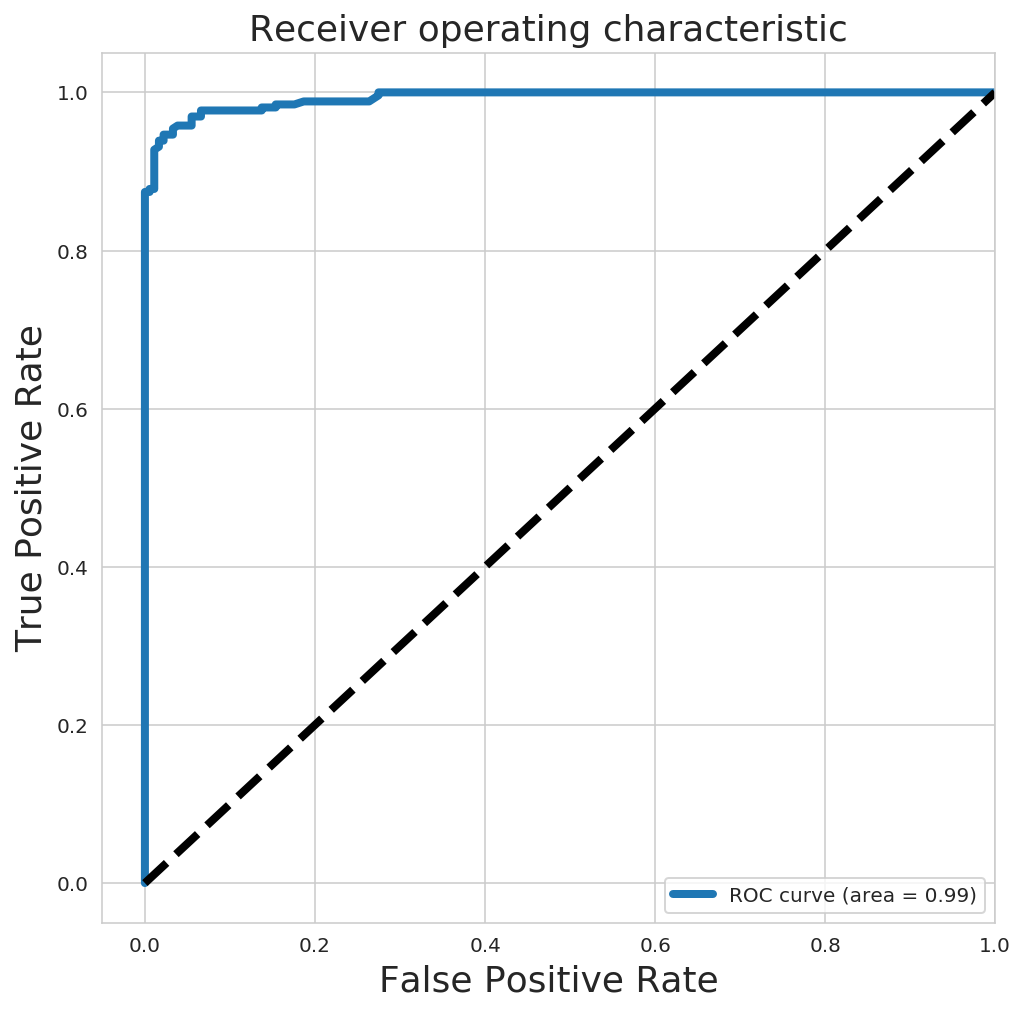

In [119]:
#Plot ROC Curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [120]:
# Classification Report
print(classification_report(y, rf.predict(X_trf)))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       182
           1       0.91      0.98      0.94       262

   micro avg       0.93      0.93      0.93       444
   macro avg       0.94      0.92      0.93       444
weighted avg       0.93      0.93      0.93       444



In [121]:
# Confusion Matrix

conmat = np.array(confusion_matrix(y, rf.predict(X_trf), labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Senior', 'Junior'],
                         columns=['Predicted Senior','Predicted junior'])

confusion

,Predicted Senior,Predicted junior
Senior,257,5
Junior,26,156


In [122]:
# Feature Importance
fi_it = pd.Series(data=rf.feature_importances_, index=X_trf.columns.values).sort_values(ascending=False)[:10]

fi_it

project                           0.010908
soap                              0.009635
experience                        0.009393
solutions                         0.007438
dynamic                           0.006521
charterhouse com sg ea license    0.006230
fixing                            0.006186
application support               0.005938
overview                          0.005675
r1110355                          0.005668
dtype: float64

#### 3.3.2 Features distinguishing Seniority in Information Technology Sector

In [123]:
jobs_bf = jobs[jobs.sector=='Banking and Finance']

In [124]:
# Let's use the other features to predict whether or not a a listing is for Junior or Senior Position

# Create a new target column where Senior = 1, Junior = 0
y = jobs_bf['seniority'].map(lambda x: 1 if x in senior else 0)

# Create new predictor matrix
X = jobs_bf[['location', 'employment_type', 'title', 'sector', 'description', 'pay']]

In [125]:
# Use CountVectorizer to vectorize description column.
# min_df=3 to remove any word that appears only in 2 listing.
vect = CountVectorizer(stop_words='english', min_df=3, ngram_range=(1,5))

# Vectorize description column
X_vect = pd.DataFrame(vect.fit_transform(X['description']).todense(), columns=vect.get_feature_names())

In [126]:
X_vect.shape

(102, 4917)

In [127]:
# Most frequent words
X_vect.sum(axis=0).sort_values(ascending=False)[:10]

data          546
business      327
experience    292
skills        199
management    192
work          176
team          175
knowledge     143
strong        127
support       125
dtype: int64

In [128]:
# Least frequent words
X_vect.sum(axis=0).sort_values(ascending=True)[:10]

key citi                             3
team time successful program         3
job purpose data                     3
job regardless                       3
job regardless marital               3
job regardless marital status        3
job regardless marital status sex    3
jobopeningid                         3
team time successful                 3
join let                             3
dtype: int64

In [129]:
# Dummy code the rest of the columns
X_dummy = pd.get_dummies(X[['location', 'employment_type', 'title', 'sector']]).reset_index(drop=True)

In [130]:
X_dummy.shape

(102, 22)

In [131]:
# Concatenate X_train_vect and X_train_dummy
X_trf = pd.concat([X_vect, X_dummy], axis=1)

In [132]:
X_trf.shape

(102, 4939)

In [133]:
"""
Commenting this section out as it takes a long time to run.

rf_params = {
    'max_depth':range(5,21),
    'n_estimators':range(5,21),
    'min_samples_split':range(2,20,5)
}

rf_gs = GridSearchCV(RandomForestClassifier(), 
                      rf_params, 
                      cv=5, 
                      verbose=1, 
                      scoring=None, 
                      n_jobs=-1)

rf_gs.fit(X_trf, y)
rf_best = rf_gs.best_estimator_

print("best parameters: {}" .format(rf_gs.best_params_))
print("best train score: {}" .format(rf_gs.best_score_))


best parameters: {'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 7}
"""

'\nCommenting this section out as it takes a long time to run.\n\nrf_params = {\n    \'max_depth\':range(5,21),\n    \'n_estimators\':range(5,21),\n    \'min_samples_split\':range(2,20,5)\n}\n\nrf_gs = GridSearchCV(RandomForestClassifier(), \n                      rf_params, \n                      cv=5, \n                      verbose=1, \n                      scoring=None, \n                      n_jobs=-1)\n\nrf_gs.fit(X_trf, y)\nrf_best = rf_gs.best_estimator_\n\nprint("best parameters: {}" .format(rf_gs.best_params_))\nprint("best train score: {}" .format(rf_gs.best_score_))\n\n\nbest parameters: {\'max_depth\': 18, \'min_samples_split\': 2, \'n_estimators\': 7}\n'

In [134]:
# Using the best paramaters from the GridSearch.

rf = RandomForestClassifier(max_depth=18, n_estimators=7, min_samples_split=2, random_state=1)

rf.fit(X_trf, y)
rf_cv_scores = cross_val_score(rf, X_trf, y, cv=10, n_jobs=-1)
rf_mean_cv_score = np.mean(rf_cv_scores)
rf_std_cv_score = np.std(rf_cv_scores)

rf_baseline = max(np.mean(y), 1-np.mean(y))

# Calculate AUC Score
fpr, tpr, _ = roc_curve(y, rf.predict_proba(X_trf)[:,1])
roc_auc = auc(fpr, tpr)

print("CV scores: {}" .format(rf_cv_scores))
print("Mean CV score: {}" .format(rf_mean_cv_score))
print("CV Score STD: {}" .format(rf_std_cv_score))
print("Test Set Baseline: {}" .format(rf_baseline))
print("AUC Score: {}" .format(roc_auc))

CV scores: [0.81818182 0.63636364 0.5        0.8        0.3        0.7
 0.6        0.8        0.2        0.7       ]
Mean CV score: 0.6054545454545455
CV Score STD: 0.20214551668873434
Test Set Baseline: 0.6862745098039216
AUC Score: 1.0


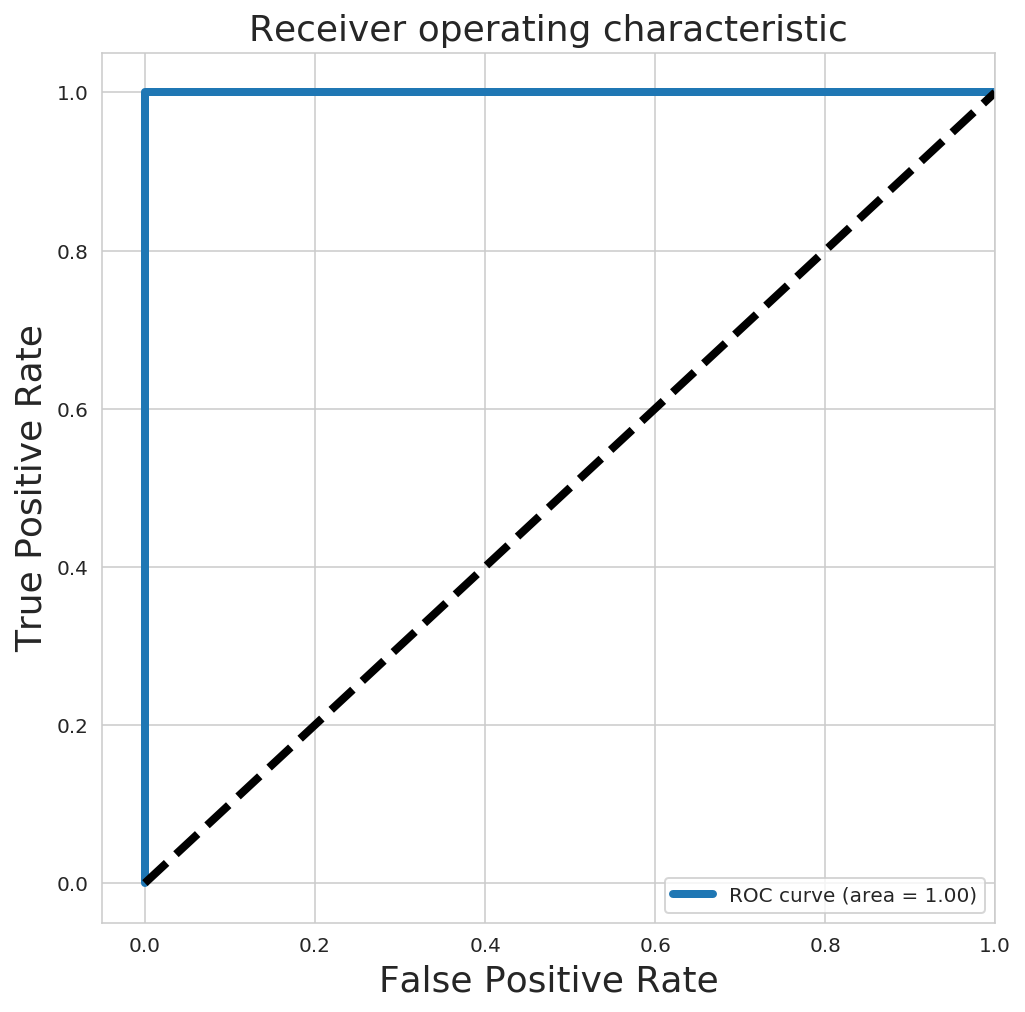

In [135]:
#Plot ROC Curve
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [136]:
# Classification Report
print(classification_report(y, rf.predict(X_trf)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.97      1.00      0.99        70

   micro avg       0.98      0.98      0.98       102
   macro avg       0.99      0.97      0.98       102
weighted avg       0.98      0.98      0.98       102



In [137]:
# Confusion Matrix

conmat = np.array(confusion_matrix(y, rf.predict(X_trf), labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Senior', 'Junior'],
                         columns=['Predicted Senior','Predicted junior'])

confusion

,Predicted Senior,Predicted junior
Senior,70,0
Junior,2,30


In [138]:
# Feature Importance
fi_bf = pd.Series(data=rf.feature_importances_, index=X_trf.columns.values).sort_values(ascending=False)[:10]

fi_bf

pressure                              0.026825
independently team                    0.026255
query optimization                    0.026099
timely accurate                       0.023940
morgan                                0.021053
materials                             0.020934
interpersonal communication skills    0.020692
finance                               0.020451
develop execute high level            0.019290
working                               0.018884
dtype: float64

#### 3.3.3 Features distinguishing Seniority between Information Technology and Banking Finance industries

In [139]:
compare = pd.DataFrame({"Feature_IT":fi_it.index.values, "Importance_IT":fi_it.values,
                        "Feature_BF":fi_bf.index.values, "Importance_BF":fi_bf.values})

compare

,Feature_IT,Importance_IT,Feature_BF,Importance_BF
0,project,0.010908,pressure,0.026825
1,soap,0.009635,independently team,0.026255
2,experience,0.009393,query optimization,0.026099
3,solutions,0.007438,timely accurate,0.023940
4,dynamic,0.006521,morgan,0.021053
5,charterhouse com sg ea license,0.006230,materials,0.020934
6,fixing,0.006186,interpersonal communication skills,0.020692
7,application support,0.005938,finance,0.020451
8,overview,0.005675,develop execute high level,0.019290
9,r1110355,0.005668,working,0.018884


##### Summary: 
1. From the comparison table of top features determining seniority between the IT and Banking/Finance industries, we can see that the features are quite different between the two industries.